In [1]:
from nrs import NRS_Model, Element, NRS_Revision, NRS_Observer_E    # классы НРС
from nrs import NRS_Data                                            # Табличные данные НРС
from nrs import q_out_simple, q_out_nozzle                          # модели расчета параметров
import matplotlib.pyplot as plt                                     # библиотеки для отрисовки получаемых данных
import networkx as nx

import logging
logger = logging.getLogger('NRS')
logging.basicConfig(level=logging.DEBUG)

# Простая схема с перекачкой

![Схема НРС](imgs/pump_to_pump_2_nozzles.png)

Схема НРС состоит из:
* 2 источников в виде насоса ПА, соединенных последовательно
* 1 магистральной рукавной линии
* 2 рабочих рукавных линий
* 2 приборов подачи воды

In [57]:
# Вычисляем проводимость насадка для ствола Б
p_nozzleB = NRS_Revision.calc_p(3.7, 40)
p_nozzleB

# Создаем элементы НРС
pump1 = Element('Н1', e_type=0, H_add=20)                                 # Стартовый напор на насосе = 20м    
pump2 = Element('Н2', e_type=1, H_add=20)

hoseM1 = Element('МРЛ1', e_type=1, s=NRS_Data.ss["77"], n=4, l=20)
hoseW1 = Element('РРЛ1', e_type=1, s=NRS_Data.ss["51"], n=3, l=20)
hoseW2 = Element('РРЛ2', e_type=1, s=NRS_Data.ss["51"], n=6, l=20)

nozzle1 = Element('Ств1', e_type=2, p=p_nozzleB, q_out = q_out_nozzle)
nozzle2 = Element('Ств2', e_type=2, p=p_nozzleB, q_out = q_out_nozzle)

# Соединяем элементы друг с другом:
pump1.append(hoseM1).append(pump2)
pump2.append(hoseW1).append(nozzle1)
pump2.append(hoseW2).append(nozzle2)

# Без наблюдателей

# Строим модель и инициируем обозревателей
model1 = NRS_Model('Простая модель от одного насоса к двум стволам, с перекачкой')
# model.build(pump1, interpretate=False);
model1.build(pump1, interpretate=True)

# Печатаем состав модели
NRS_Revision.print_model_elements(model1)

Новый элемент НРС: Н1
Новый элемент НРС: Н2
Новый элемент НРС: МРЛ1
Новый элемент НРС: РРЛ1
Новый элемент НРС: РРЛ2
Новый элемент НРС: Ств1
Новый элемент НРС: Ств2
Новая модель: Простая модель от одного насоса к двум стволам, с перекачкой
all:
  Н1
  МРЛ1
  Н2
  РРЛ1
  Ств1
  РРЛ2
  Ств2
in:
  Н1
out:
  Ств1
  Ств2


In [58]:
# Рассчет 
model1.calc(accuracy=0.05)
print(model1.summaryQ())

Расчет НРС не возможен
6.552530741280176


In [61]:
NRS_Revision.print_element_state(pump2)

elements_next: [<nrs.Element object at 0x000001D87A8B68D0>, <nrs.Element object at 0x000001D87A6C9250>]
elements_previous: [<nrs.Element object at 0x000001D87A9000D0>]
type: 1
name: Н2
q: 6.552530741280176
s: 0
H_in: 17.444403938764626
h: 0.0
z: 0
p: 1
n: 1
q_out: <function q_out_simple at 0x000001D8766E7A60>
H_add: 20
observer: None
l: 0
H_out: 37.44440393876462


In [62]:
print(model1.summaryQ())

pump2.set_H_add(40)
model1.calc(accuracy=0.005)

print(model1.summaryQ())

6.552530741280176
8.010999932976922


In [63]:
hoseM1.n = 5
model1.calc(accuracy=0.005)
print(model1.summaryQ())
hoseM1.n = 8
model1.calc(accuracy=0.005)
print(model1.summaryQ())
hoseM1.n = 11
model1.calc(accuracy=0.005)
print(model1.summaryQ())
hoseM1.n = 14
model1.calc(accuracy=0.005)
print(model1.summaryQ())
hoseM1.n = 17
model1.calc(accuracy=0.005)
print(model1.summaryQ())

7.949194926322782
7.767235796493592
7.597977324345875
7.436205769252888
7.289298522659095


In [6]:
hoseM1.n = 2
model1.calc(accuracy=0.005)
print(model1.summaryQ())

8.1449313174344


In [7]:
# Исправляет перегрев модели, сбрасывая входящие напоры. Для много стартовых моделей неприемлемо, скорее всего.
pump1.set_H_in(20)

In [8]:
model1.build(pump1, interpretate=True)

# Схема со слиянием нескольких элементов в одну линию


![Схема НРС](imgs/2_pump_to_1_nozzle.png)

Схема НРС состоит из:
* 2 источников в виде насоса ПА
* 2 магистральных рукавных линий
* 1 рабочей рукавной линии
* 1 прибора подачи воды

In [2]:
# Вычисляем проводимость насадка для ствола Б
p_nozzleL = NRS_Revision.calc_p(20, 60)
print(f'Проводимость лафетного ствола {p_nozzleL}')

# Создаем элементы НРС
pump1 = Element('Н1', e_type=0, H_add=80)                                 
pump2 = Element('Н2', e_type=0, H_add=80)

hoseM1 = Element('МРЛ1', e_type=1, s=NRS_Data.ss["77"], n=8, l=20)
hoseM2 = Element('МРЛ2', e_type=1, s=NRS_Data.ss["77"], n=4, l=20)
hoseW1 = Element('РРЛ1', e_type=1, s=NRS_Data.ss["77"], n=4, l=20)

joiner1 = Element('ВС1', e_type=1, ri=2, ro=1)

nozzle1 = Element('Ств1', e_type=2, p=p_nozzleL, q_out = q_out_nozzle)

# Соединяем элементы друг с другом:
pump1.append(hoseM1).append(joiner1)
pump2.append(hoseM2).append(joiner1).append(hoseW1).append(nozzle1)

# Без наблюдателей

# Строим модель и инициируем обозревателей
model2 = NRS_Model('Сложная модель со слиянием нескольких элементов в одну линию')
# model.build(pump1, interpretate=False);
model2.build(pump1, interpretate=True)

# Печатаем состав модели
NRS_Revision.print_model_elements(model2)

INFO:NRS:Новый элемент НРС: Н1
INFO:NRS:Новый элемент НРС: МРЛ1
INFO:NRS:Новый элемент НРС: ВС1
INFO:NRS:Новый элемент НРС: РРЛ1
INFO:NRS:Новый элемент НРС: Ств1
INFO:NRS:Новый элемент НРС: МРЛ2
INFO:NRS:Новый элемент НРС: Н2


Проводимость лафетного ствола 2.581988897471611
Новая модель: Сложная модель со слиянием нескольких элементов в одну линию
all:
  Н1
  МРЛ1
  ВС1
  РРЛ1
  Ств1
  МРЛ2
  Н2
in:
  Н1
  Н2
out:
  Ств1


In [3]:
model2.calc(accuracy=0.005)
print(model2.summaryQ())

DEBUG:NRS:Расчет НРС не возможен


18.857260790083174


In [4]:
print('Насос №1')
NRS_Revision.print_element_state(pump1, ['H_add', 'q'])
print('Насос №2')
NRS_Revision.print_element_state(pump2, ['H_add', 'q'])

Насос №1
H_add: 80
q: 9.428630395041587
Насос №2
H_add: 80
q: 9.428630395041587


In [5]:
NRS_Revision.print_element_state(hoseM1)

elements_next: [<nrs.Element object at 0x00000253806E0910>]
elements_previous: [<nrs.Element object at 0x00000253806E0110>]
type: 1
name: МРЛ1
q: 9.428630395041587
s: 0.015
H_in: 80.0
h: 10.6642229296875
z: 0
p: 1
n: 8
q_out: <function q_out_simple at 0x00000253FEEA7C40>
H_add: 0
observer: None
l: 20
ri: 1
ro: 1
H_out: 69.3357770703125


In [6]:
NRS_Revision.print_element_state(hoseM2)

elements_next: [<nrs.Element object at 0x00000253806E0910>]
elements_previous: [<nrs.Element object at 0x00000253FF9B1290>]
type: 1
name: МРЛ2
q: 9.428630395041587
s: 0.015
H_in: 80.0
h: 5.33211146484375
z: 0
p: 1
n: 4
q_out: <function q_out_simple at 0x00000253FEEA7C40>
H_add: 0
observer: None
l: 20
ri: 1
ro: 1
H_out: 74.66788853515625


In [7]:
hoseM1.H_in

80.0

In [8]:
# hoseM1.get_h()
NRS_Revision.print_element_state(hoseM1, ['H_add', 'H_out', 'q', 'H_in', 'h'])

H_add: 0
H_out: 69.3357770703125
q: 9.428630395041587
H_in: 80.0
h: 10.6642229296875


In [9]:
print(hoseM1.h + hoseM1.H_in)

90.6642229296875


# Тест рисования графа

Оставлено на будущую работу

In [12]:
# Создаем модель НРС
model3 = NRS_Model('Модель от одного насоса к пяти стволам через два разветвления')

# Создаем элементы модели
pump = Element('Н1', 0, H_add=40)
hoseM_1 = Element('МРЛ Н-Р1', 1, s=NRS_Data.ss["77"], n=3, l=20)

splitter_1 = Element('Р1', 1, ri=1, ro=3)
hoseW_11 = Element('РРЛ Р1-1', 1, s=NRS_Data.ss["51"], n=3, l=20)
nozzle_11 = Element('Ствол Р1-1(Б)', 2, p=0.585, q_out = q_out_nozzle)
hoseW_12 = Element('РРЛ Р1-2', 1, s=NRS_Data.ss["51"], n=1, l=20)
nozzle_12 = Element('Ствол Р1-2(Б)', 2, p=0.585, q_out = q_out_nozzle)
hoseM_12 = Element('МРЛ Р1-Р2', 1, s=NRS_Data.ss["77"], n=3, l=20)

splitter_2 = Element('Р2', 1, ri=1, ro=3)
hoseW_21 = Element('РРЛ Р2-1', 1, s=NRS_Data.ss["51"], n=1, l=20)
nozzle_21 = Element('Ствол Р2-1(Б)', 2, p=0.585, q_out = q_out_nozzle)
hoseW_22 = Element('РРЛ Р2-2', 1, s=NRS_Data.ss["77"], n=1, l=20)
nozzle_22 = Element('Ствол Р2-2(А)', 2, p=1.17, q_out = q_out_nozzle)
hoseW_23 = Element('РРЛ Р2-3', 1, s=NRS_Data.ss["51"], n=3, l=20)
nozzle_23 = Element('Ствол Р2-3(Б)', 2, p=0.585, q_out = q_out_nozzle)

# Соединяем элементы модели вместе в НРС
pump.append(hoseM_1).append(splitter_1).append(hoseM_12).append(splitter_2)

splitter_1.append(hoseW_11).append(nozzle_11)   # Рукавная линия к стволу №1
splitter_1.append(hoseW_12).append(nozzle_12)   # Рукавная линия к стволу №2

splitter_2.append(hoseW_21).append(nozzle_21)   # Рукавная линия к стволу №3
splitter_2.append(hoseW_22).append(nozzle_22)   # Рукавная линия к стволу №4
splitter_2.append(hoseW_23).append(nozzle_23)   # Рукавная линия к стволу №5

# Добавляем обозревателей
NRS_Observer_E(pump, ['q', 'H_in'])
NRS_Observer_E(nozzle_11, ['q', 'H_in'])
NRS_Observer_E(nozzle_12, ['q', 'H_in'])
NRS_Observer_E(nozzle_21, ['q', 'H_in'])
NRS_Observer_E(nozzle_22, ['q', 'H_in'])
NRS_Observer_E(nozzle_23, ['q', 'H_in'])

# Строим модель и инициируем обозревателей
model3.build(pump, interpretate=True)
model3.observersInit()

# Расчет
model3.calc(accuracy=0.005)
print(model3.summaryQ())

INFO:NRS:Новый элемент НРС: Н1
INFO:NRS:Новый элемент НРС: МРЛ Н-Р1
INFO:NRS:Новый элемент НРС: Р1
INFO:NRS:Новый элемент НРС: МРЛ Р1-Р2
INFO:NRS:Новый элемент НРС: Р2
INFO:NRS:Новый элемент НРС: РРЛ Р2-1
INFO:NRS:Новый элемент НРС: Ствол Р2-1(Б)
INFO:NRS:Новый элемент НРС: РРЛ Р2-2
INFO:NRS:Новый элемент НРС: Ствол Р2-2(А)
INFO:NRS:Новый элемент НРС: РРЛ Р2-3
INFO:NRS:Новый элемент НРС: Ствол Р2-3(Б)
INFO:NRS:Новый элемент НРС: РРЛ Р1-1
INFO:NRS:Новый элемент НРС: Ствол Р1-1(Б)
INFO:NRS:Новый элемент НРС: РРЛ Р1-2
INFO:NRS:Новый элемент НРС: Ствол Р1-2(Б)
DEBUG:NRS:Расчет НРС не возможен


Новая модель: Модель от одного насоса к пяти стволам через два разветвления
16.65105346870495


Расстояние до Н1 180 м


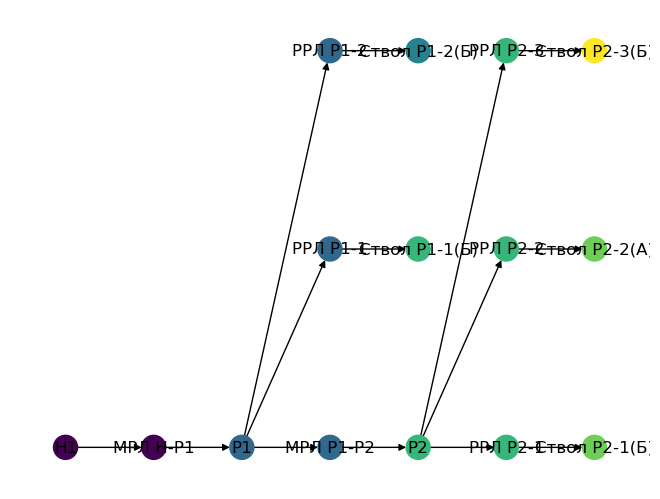

In [13]:
model = model3
# Построение графа НРС
G = nx.DiGraph()
# Узлы - на каждый элемент
for elmnt in model.elmnts:
    G.add_node(elmnt.name, q=elmnt.q)
# Ребра - на каждую связь
for elmnt in model.elmnts:
    for elmnt_next in elmnt.elements_next:
        G.add_edge(elmnt.name, elmnt_next.name, L=elmnt.get_L())

# Расчет расстояния до элементов
# for elmnt in model.elmnts_out:
#     paths = nx.shortest_path_length(G, target = elmnt.name, weight='L')
#     nx.set_node_attributes(G, paths, 'L')   # Здесь нужна другая логика
#     print(f'Расстояние до {elmnt.name} {max(paths.values())} м')
for elmnt in model.elmnts_in:
    paths = nx.shortest_path_length(G, source = elmnt.name, weight='L')
    nx.set_node_attributes(G, paths, 'L')   # Здесь нужна другая логика
    print(f'Расстояние до {elmnt.name} {max(paths.values())} м')    

# Печать графа НРС
pos={}
pos_list=[]
level=0
for eo in model.elmnts_in:
    v = eo.name
    spl = dict(nx.single_source_shortest_path_length(G, v))
    for nd, p in spl.items():
        if not nd in pos.keys():
            level_rize=level
            cpos = (p,level_rize)
            while cpos in pos_list:
                level_rize+=1
                cpos = (p,level_rize)
            pos[nd]=cpos
            pos_list.append(cpos)
    level+=1

# nc = [nd[1]['q'] for nd in list(G.nodes(data=True))]
nc = [nd[1]['L'] for nd in list(G.nodes(data=True))]
nx.draw(G, pos=pos, with_labels=True, node_color=nc)
plt.show()

In [14]:
list(G.nodes(data=True))

[('Н1', {'q': 16.65105346870495, 'L': 0}),
 ('МРЛ Н-Р1', {'q': 16.65105346870495, 'L': 0}),
 ('Р1', {'q': 16.65105346870495, 'L': 60}),
 ('МРЛ Р1-Р2', {'q': 10.766175275413213, 'L': 60}),
 ('Р2', {'q': 10.766175275413213, 'L': 120}),
 ('РРЛ Р2-1', {'q': 2.702849207520263, 'L': 120}),
 ('Ствол Р2-1(Б)', {'q': 2.702849207520263, 'L': 140}),
 ('РРЛ Р2-2', {'q': 5.468817291420171, 'L': 120}),
 ('Ствол Р2-2(А)', {'q': 5.468817291420171, 'L': 140}),
 ('РРЛ Р2-3', {'q': 2.594508776472779, 'L': 120}),
 ('Ствол Р2-3(Б)', {'q': 2.594508776472779, 'L': 180}),
 ('РРЛ Р1-1', {'q': 2.882282693010855, 'L': 60}),
 ('Ствол Р1-1(Б)', {'q': 2.882282693010855, 'L': 120}),
 ('РРЛ Р1-2', {'q': 3.002595500280884, 'L': 60}),
 ('Ствол Р1-2(Б)', {'q': 3.002595500280884, 'L': 80})]